In [9]:
from langgraph.graph import START,StateGraph
from langgraph.prebuilt import ToolNode,tools_condition
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage,SystemMessage
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
import os

from sqlalchemy.util.typing import includes_none

In [10]:
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv("groq_api")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

#Model Initialization:
gpt = ChatGroq(
    model = "openai/gpt-oss-20b",
    temperature=0,
)
gpt.profile

{'max_input_tokens': 131072,
 'max_output_tokens': 32768,
 'image_inputs': False,
 'audio_inputs': False,
 'video_inputs': False,
 'image_outputs': False,
 'audio_outputs': False,
 'video_outputs': False,
 'reasoning_output': True,
 'tool_calling': True}

In [14]:
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    max_results=3,
    search_depth = "advanced",
    includes_domains = ["who.int"],
    include_raw_content = True
)
question = "What is the latest WHO report on malaria"
search_results = tavily_search.invoke(question)

In [18]:
for answer in search_results['results']:
    print("===>"*10)
    print(answer)
    print("====>"*10)

===>===>===>===>===>===>===>===>===>===>
{'url': 'https://www.who.int/teams/global-malaria-programme/reports/world-malaria-report-2025', 'title': 'World malaria report 2025 - World Health Organization (WHO)', 'content': 'Antimalarial drug resistance challenging progress\n\nEach year, WHO’s _World malaria report_ provides a comprehensive and up-to-date assessment of trends in malaria control and elimination across the globe. The 2024 edition reviews investments in malaria programmes and research and assesses progress across all major intervention areas – prevention, diagnosis, treatment, elimination and surveillance – in 80 malaria-endemic countries. [...] This year’s report spotlights the growing threat of antimalarial drug resistance. Partial resistance to artemisinin derivatives – the backbone of malaria treatments after failures of chloroquine and sulfadoxine-pyrimethamine\u200b – has now been confirmed or suspected in at least 8 countries in Africa, and there are potential signs of

In [21]:
from langchain_community.document_loaders import WebBaseLoader

scraped_docs = []
urls = [result.get("url") for result in search_results["results"] if result.get("url")]
print(f"Found URLs: {urls}")

if not urls:
    print("No valid URLs in search results.")

for url in urls:
    try:
        print(f"Scraping {url}...")
        loader = WebBaseLoader(url)
        docs = loader.load()
        for doc in docs:
            doc.metadata["source"] = url
        scraped_docs.extend(docs)
    except Exception as e:
        print(f"Error scraping {url}: {e}")

print(f"Scraped {len(scraped_docs)} documents.")

Found URLs: ['https://www.who.int/teams/global-malaria-programme/reports/world-malaria-report-2025', 'https://www.who.int/teams/global-malaria-programme/reports/world-malaria-report-2024', 'https://www.who.int/news-room/fact-sheets/detail/malaria']
Scraping https://www.who.int/teams/global-malaria-programme/reports/world-malaria-report-2025...
Scraping https://www.who.int/teams/global-malaria-programme/reports/world-malaria-report-2024...
Scraping https://www.who.int/news-room/fact-sheets/detail/malaria...
Scraped 3 documents.


In [23]:
scraped_docs[2]

Document(metadata={'source': 'https://www.who.int/news-room/fact-sheets/detail/malaria', 'title': '\r\n\tMalaria\r\n', 'description': 'WHO fact sheet on malaria providing key facts, definition, information on transmission, symptoms, who is at risk, diagnosis, treatment, prevention, insecticide resistance, surveillance, elimination, vaccines and WHO response.', 'language': 'en'}, page_content="      \r\n\tMalaria\r\n                     \n   Skip to main content       \n\n\n \n\n\n\n\n\n\n\nGlobal\n\n\nRegions\n\n\n\n\n\n\n\nWHO Regional websites\n\n\n\n\n\n\n\nAfrica\n\n\n\n\n\nAmericas\n\n\n\n\n\nSouth-East Asia\n\n\n\n\n\nEurope\n\n\n\n\n\nEastern Mediterranean\n\n\n\n\n\nWestern Pacific\n\n\n\n\n\n\n\n\n\n   \n\n\n\n\n\n\n\n\n\n\n\n\n\nWhen autocomplete results are available use up and down arrows to review and enter to select.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\r\n        Select language\r\n    \n\nSelect language\nEnglish\nالعربية\n中文\nFrançais\nРусский\nEspañol\n\n\n\n\n        \n  

In [24]:

from langchain_community.document_loaders import WebBaseLoader
from langchain_tavily import TavilySearch
from langchain_core.documents import Document
from typing import List
from typing_extensions import TypedDict

# Define the state
class GraphState(TypedDict):
    question: str
    documents: List[Document]
    sender: str

# --- Your Function (with st.warning) ---
def web_search_node(state: GraphState) -> GraphState:
    """Searches the web for information, then scrapes the content from the resulting URLs."""
    print("--- Calling Web Search Node ---")
    question = state["question"]

    tavily_search = TavilySearch(
        max_results=2,
        search_depth="advanced",
        include_domains=["who.int"]
    )
    search_results = tavily_search.invoke(question)

    scraped_docs = []
    if not search_results or "results" not in search_results:
        print("No search results found.")
        return {"documents": [], "sender": "web_search_node"}

    urls = [result.get("url") for result in search_results["results"] if result.get("url")]
    print(f"Found URLs: {urls}")

    if not urls:
        print("No valid URLs in search results.")
        return {"documents": [], "sender": "web_search_node"}

    for url in urls:
        try:
            print(f"Scraping {url}...")
            loader = WebBaseLoader(url)
            docs = loader.load()
            for doc in docs:
                doc.metadata["source"] = url
            scraped_docs.extend(docs)
        except Exception as e:
            print(f"Error scraping {url}: {e}")

    print(f"Scraped {len(scraped_docs)} documents.")
    return {"documents": scraped_docs, "sender": "web_search_node"}

In [25]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(GraphState)
workflow.add_node("web_search", web_search_node)
workflow.set_entry_point("web_search")
workflow.add_edge("web_search", END)

app = workflow.compile()

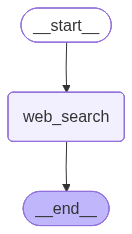

In [27]:
display(app)

In [26]:
inputs = {"question": "What is the latest WHO report on malaria?"}
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"\n--- Output from Node: {key} ---")

        if 'documents' in value and value['documents']:
            print(f"Documents found: {len(value['documents'])}")
            print("-" * 30)

            for i, doc in enumerate(value['documents']):
                print(f"\n--- Document {i+1} ---")
                print(f"Source: {doc.metadata.get('source', 'No source available')}")
                # print("\nContent:")
                # print(doc.page_content)
        else:
            print("No documents found in this step.")

--- Calling Web Search Node ---
Found URLs: ['https://www.who.int/teams/global-malaria-programme/reports/world-malaria-report-2025', 'https://www.who.int/news-room/fact-sheets/detail/malaria']
Scraping https://www.who.int/teams/global-malaria-programme/reports/world-malaria-report-2025...
Scraping https://www.who.int/news-room/fact-sheets/detail/malaria...
Scraped 2 documents.

--- Output from Node: web_search ---
Documents found: 2
------------------------------

--- Document 1 ---
Source: https://www.who.int/teams/global-malaria-programme/reports/world-malaria-report-2025

--- Document 2 ---
Source: https://www.who.int/news-room/fact-sheets/detail/malaria
